# Import Required Libraries
Import libraries such as TensorFlow, Keras, NumPy, Matplotlib, and others required for deep learning and visualization.

In [52]:
import os
import shutil
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load and Explore Dataset
Load the butterfly dataset and explore its structure, including the number of classes and sample images.

In [54]:
# Load and Explore Dataset

train_csv_path = "training_set.csv"
test_csv_path = "testing_set.csv"
train_img_dir = r"C:\Users\admin\Downloads\DL_Assignment2\train"
test_img_dir = r"C:\Users\admin\Downloads\DL_Assignment2\test"

In [60]:
train_df=pd.read_csv(train_csv_path)
train_df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [64]:
test_df=pd.read_csv(test_csv_path)
test_df.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


# Data Preprocessing
Resize images to a fixed size, normalize pixel values to [0, 1], and apply data augmentation techniques such as rotation, flipping, and zooming.

In [66]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [68]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [72]:
train_data = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_img_dir,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

Found 5200 validated image filenames belonging to 75 classes.


In [74]:
val_data = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_img_dir,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

Found 1299 validated image filenames belonging to 75 classes.


In [76]:
test_data = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_img_dir,
    x_col="filename",
    y_col=None,  # No labels for test
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

Found 2786 validated image filenames.


# Model Development
Use a pre-trained model like VGG16 or ResNet for feature extraction, and fine-tune it or build a custom CNN architecture for classification.

In [78]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [80]:
base_model.trainable = False

In [82]:
num_classes = len(train_data.class_indices)

In [84]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

In [88]:
model = Model(inputs=base_model.input, outputs=x)

In [90]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [92]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,431,627 (9.28 MB)

 Trainable params: 173,643 (678.29 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Training and Evaluation
Train the model using appropriate loss functions and optimizers. Evaluate the model using metrics such as accuracy, precision, recall, and F1-score.

In [94]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,  # Reduce if training takes too long
    verbose=1
)

C:\Users\admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 480s 3s/step - accuracy: 0.2175 - loss: 3.5058 - val_accuracy: 0.6451 - val_loss: 1.4100
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.7202 - loss: 1.0955 - val_accuracy: 0.7306 - val_loss: 0.9664
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.7964 - loss: 0.7294 - val_accuracy: 0.7752 - val_loss: 0.8141
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.8518 - loss: 0.5407 - val_accuracy: 0.7829 - val_loss: 0.7563
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 414s 3s/step - accuracy: 0.8704 - loss: 0.4554 - val_accuracy: 0.8029 - val_loss: 0.6716
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.8973 - loss: 0.3755 - val_accuracy: 0.8229 - val_loss: 0.6165
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.8990 - loss: 0.3625 - val_accuracy: 0.8306 - val_loss: 0.6234
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.9120 - loss: 0.3061 - val_accu

In [102]:
from sklearn.metrics import classification_report

# Get True & Predicted Labels
y_true = val_data.classes
y_pred = model.predict(val_data)
y_pred_classes = y_pred.argmax(axis=1)

# Print Classification Report
print(classification_report(y_true, y_pred_classes, target_names=list(train_data.class_indices.keys())))

41/41 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step
                           precision    recall  f1-score   support

                   ADONIS       0.00      0.00      0.00        19
AFRICAN GIANT SWALLOWTAIL       0.00      0.00      0.00        17
           AMERICAN SNOOT       0.00      0.00      0.00        16
                    AN 88       0.00      0.00      0.00        17
                  APPOLLO       0.00      0.00      0.00        14
                    ATALA       0.03      0.04      0.03        23
 BANDED ORANGE HELICONIAN       0.00      0.00      0.00        19
           BANDED PEACOCK       0.00      0.00      0.00        16
            BECKERS WHITE       0.05      0.06      0.05        16
         BLACK HAIRSTREAK       0.10      0.07      0.09        27
              BLUE MORPHO       0.00      0.00      0.00        10
        BLUE SPOTTED CROW       0.00      0.00      0.00        16
           BROWN SIPROETA       0.00      0.00      0.00        26
            CABBAGE WH

In [106]:
model.save("butterfly_classifier.h5")

# Visualization
Plot training and validation accuracy/loss curves. Visualize predictions on a few test images along with their true labels.

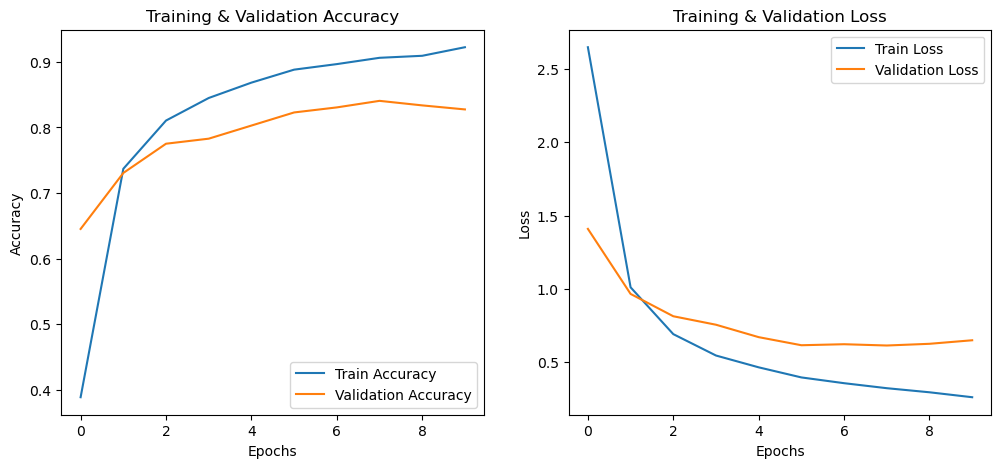

In [108]:
import matplotlib.pyplot as plt

# Plot Accuracy & Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")

plt.show()


In [110]:
import numpy as np

# Predict Test Images
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Map Class Indices to Labels
labels = {v: k for k, v in train_data.class_indices.items()}
predicted_labels = [labels[i] for i in predicted_classes]


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step


# Report Observations
Summarize the approach, results, and observations. Discuss challenges faced and potential improvements.

In [ ]:
{}